## Data Collection

In [79]:
import pandas as pd

df = pd.read_csv("train.csv")

df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [ ]:
df.isnull().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

## EDA

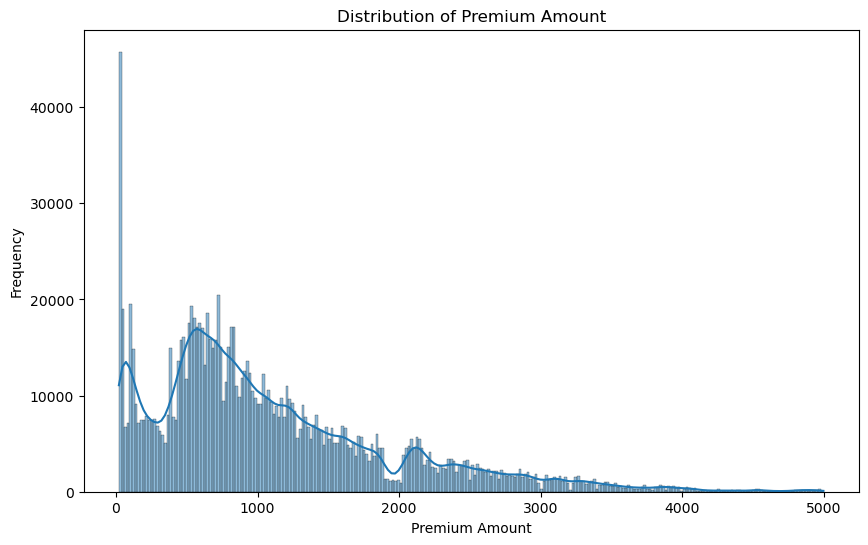

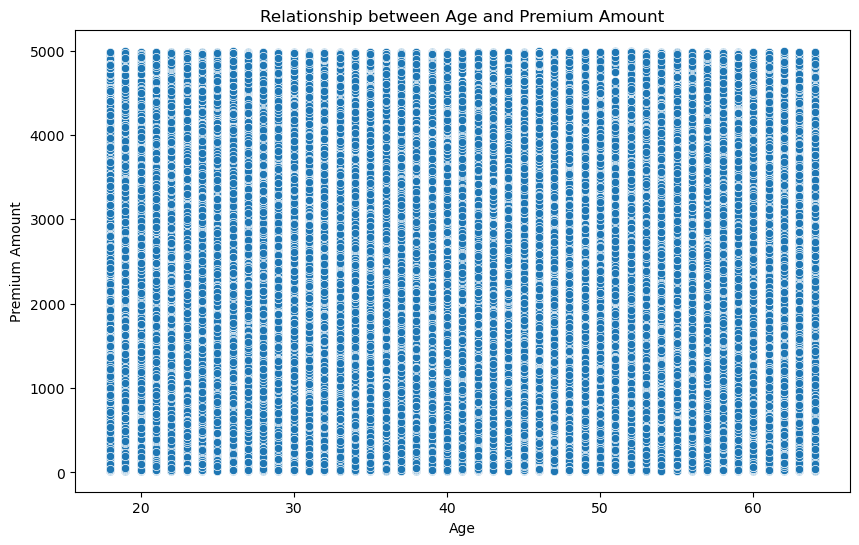

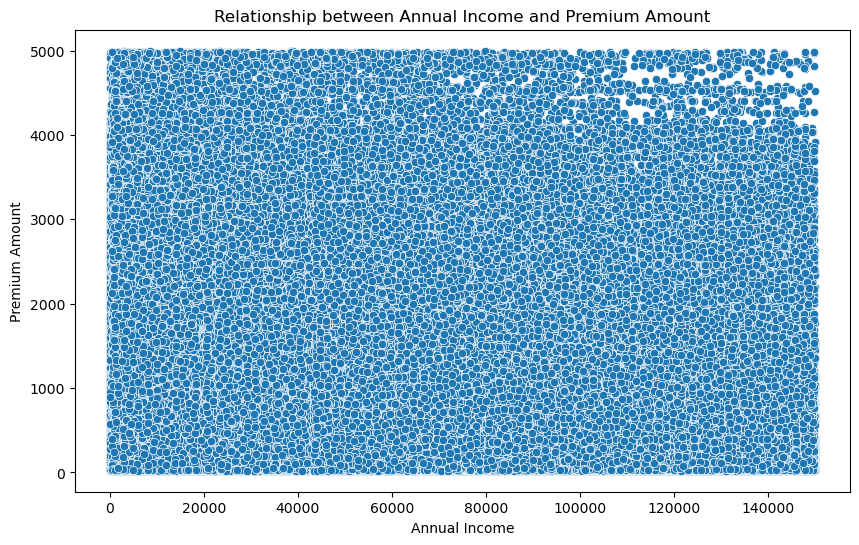

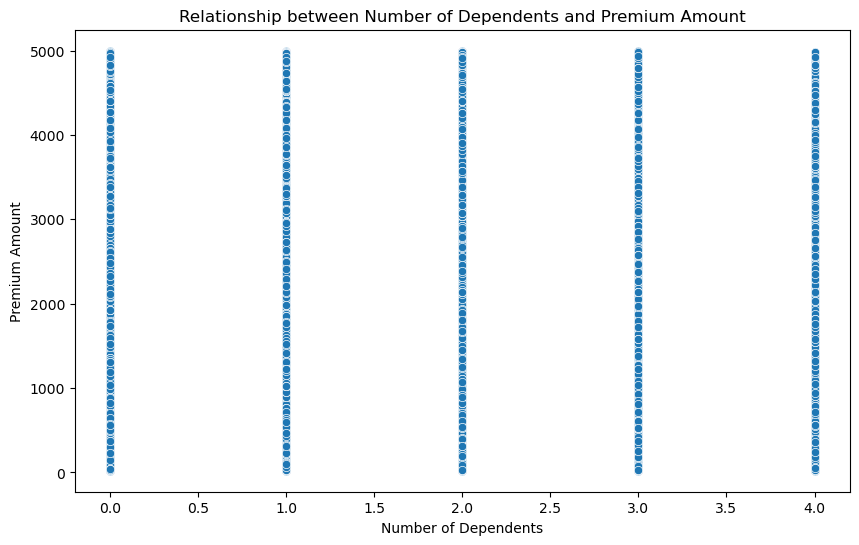

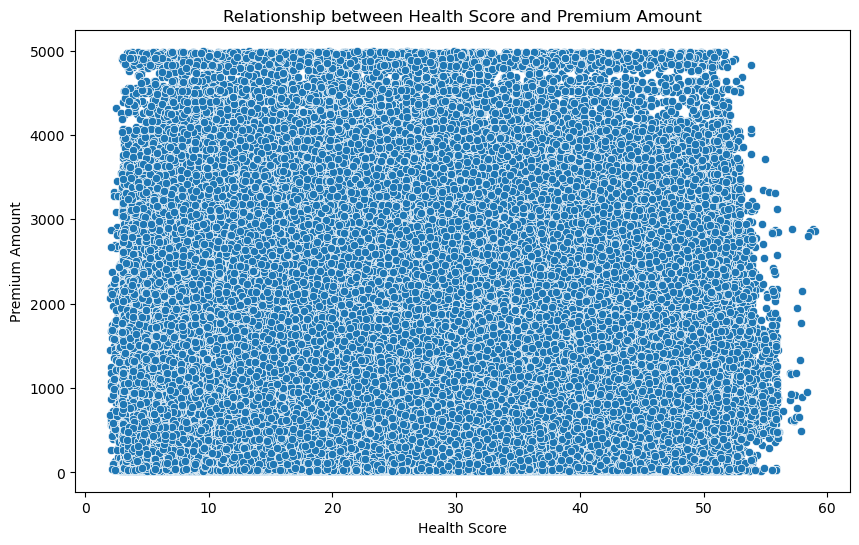

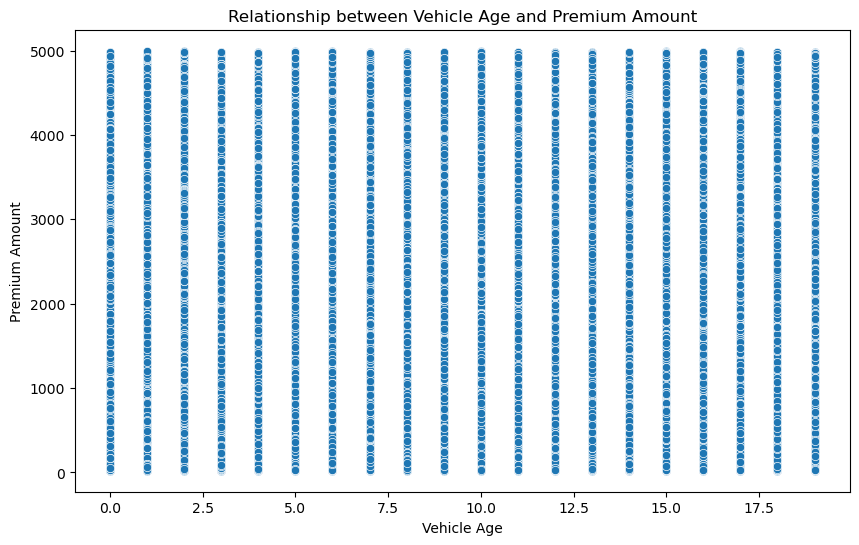

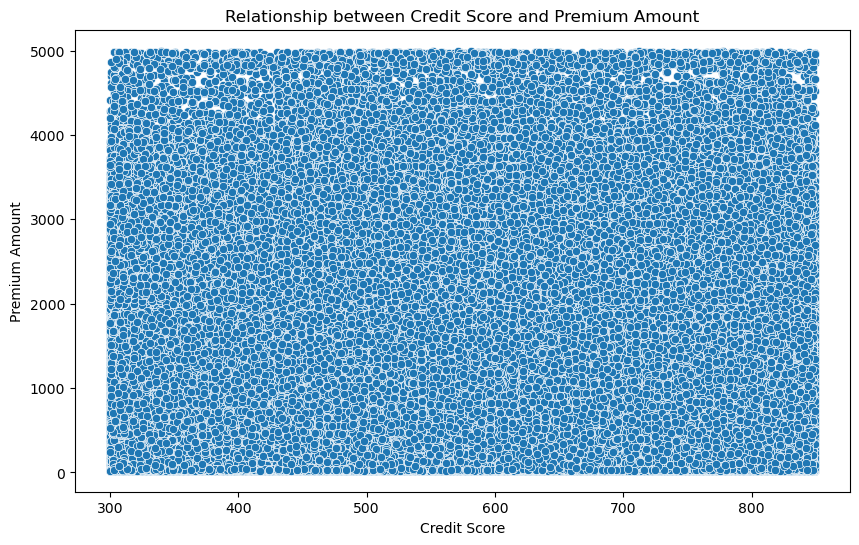

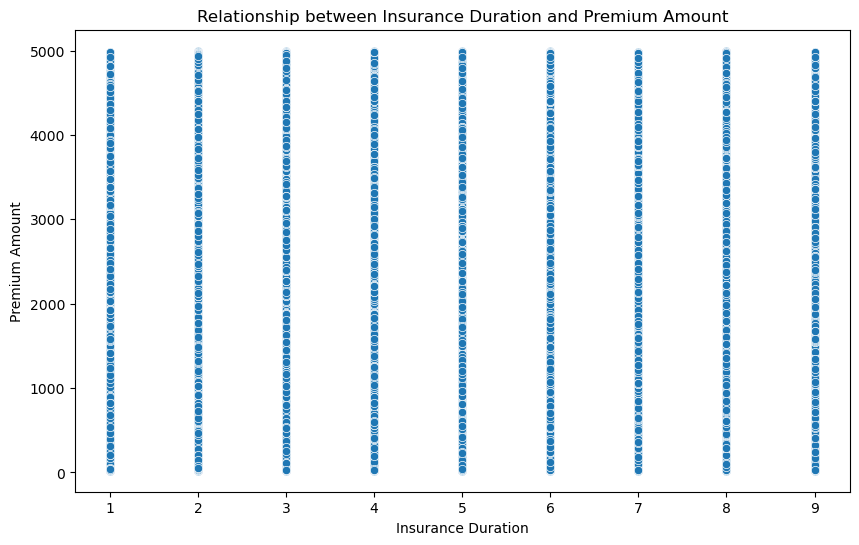

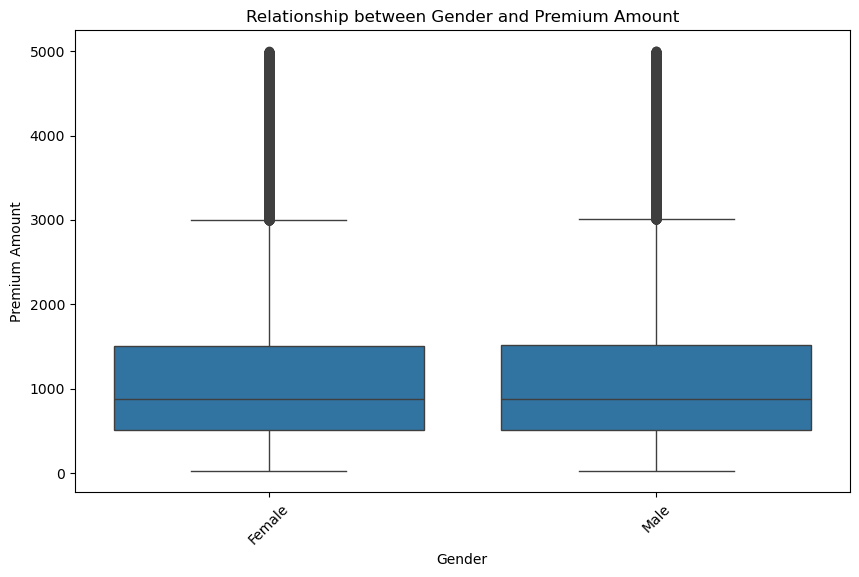

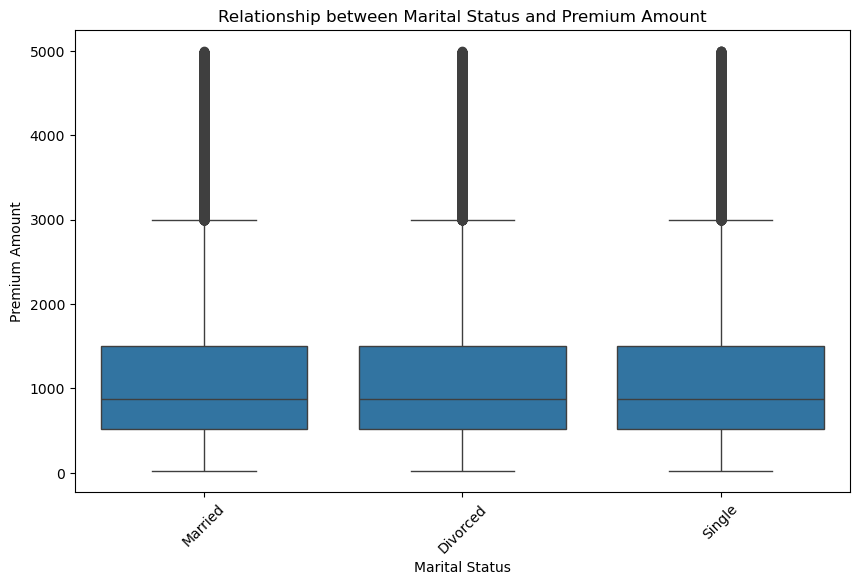

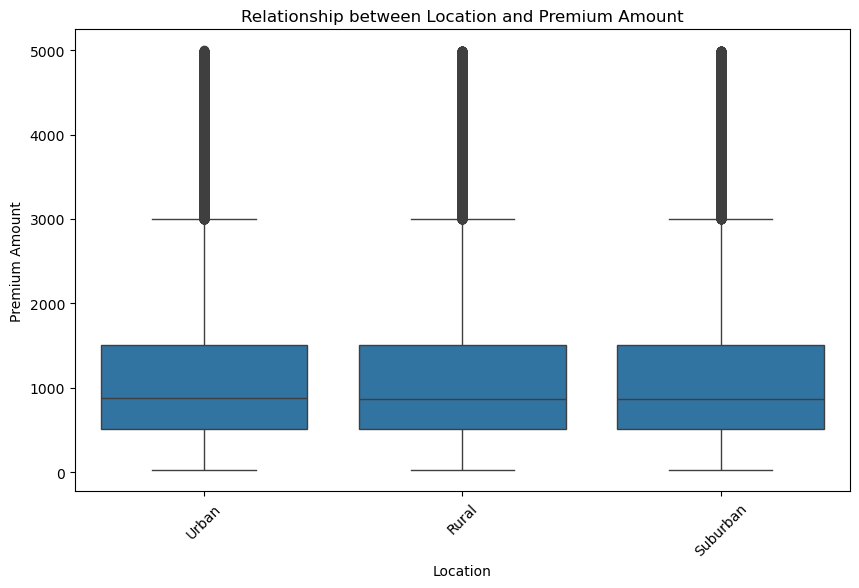

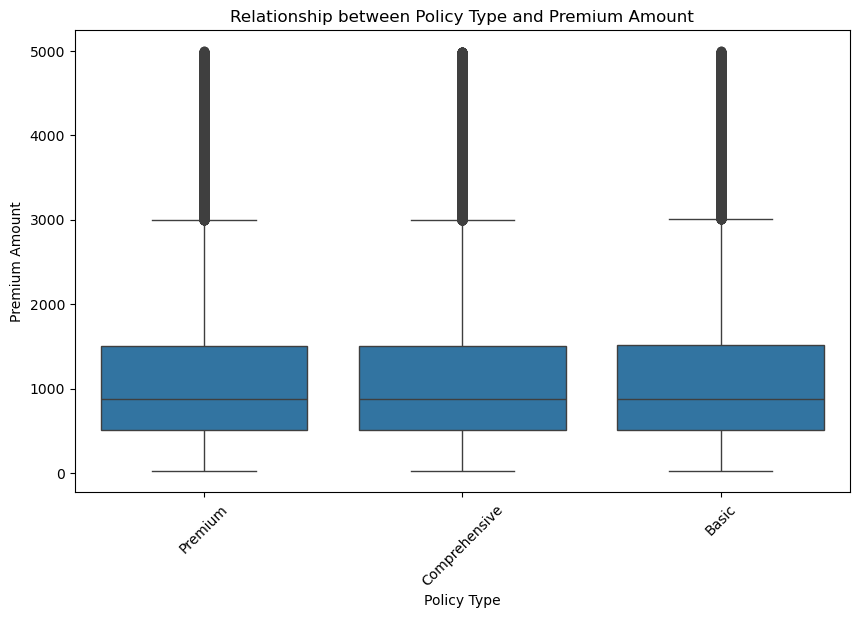

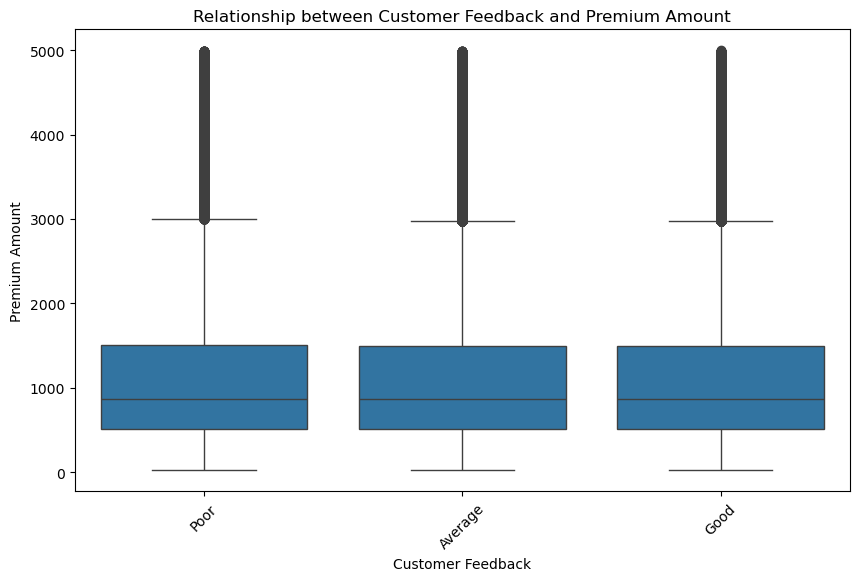

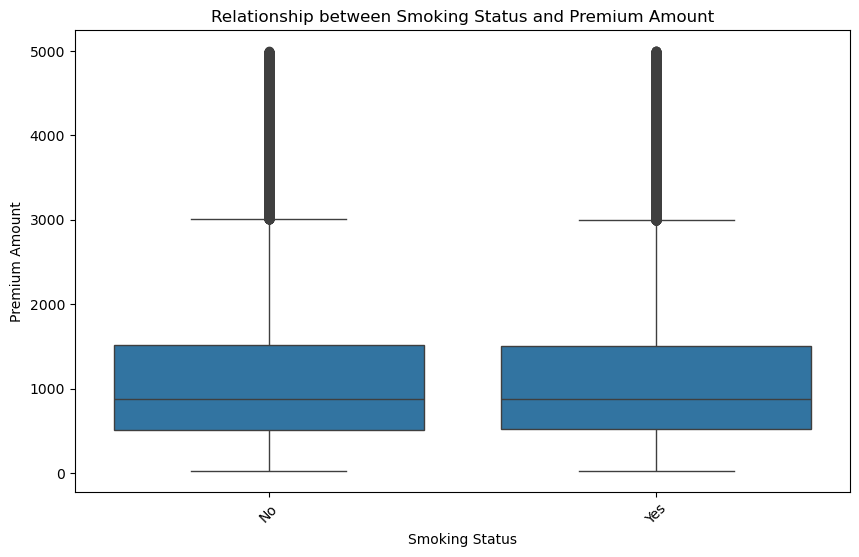

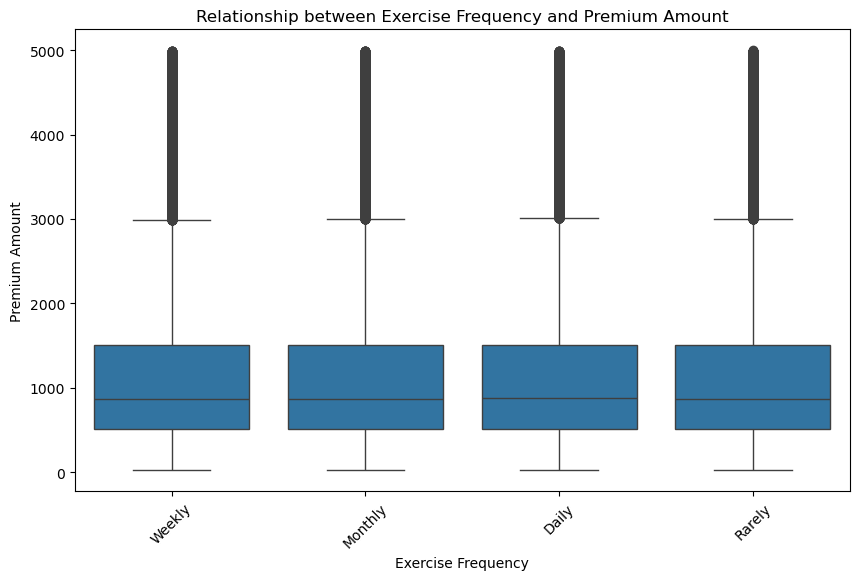

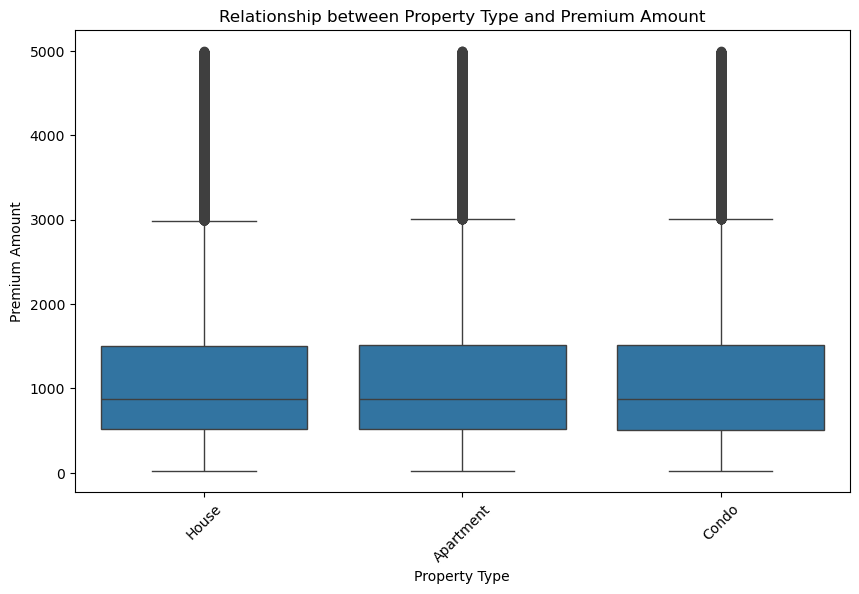

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


# Distribution of Premium Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Premium Amount'], kde=True)
plt.title('Distribution of Premium Amount')
plt.xlabel('Premium Amount')
plt.ylabel('Frequency')
plt.show()

# Relationship between Premium Amount and other numerical features
numeric_features = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[feature], y=df['Premium Amount'])
    plt.title(f'Relationship between {feature} and Premium Amount')
    plt.xlabel(feature)
    plt.ylabel('Premium Amount')
    plt.show()

# Relationship between Premium Amount and categorical features
categorical_features = ['Gender', 'Marital Status', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[feature], y=df['Premium Amount'])
    plt.title(f'Relationship between {feature} and Premium Amount')
    plt.xlabel(feature)
    plt.ylabel('Premium Amount')
    plt.xticks(rotation=45)
    plt.show()

## Data Preprocessing

In [81]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')


class DataPreprocessor:
    def __init__(self):
        self.label_encoders = {}
        self.one_hot_encoder = OneHotEncoder(sparse_output=False)
        

    def preprocess_data(self, df):
        
        numerical_cols = [
            'Age', 'Annual Income', 'Health Score', 
            'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Previous Claims'
        ]
        
        categorical_cols = [
            'Marital Status', 'Number of Dependents', 'Occupation', 'Customer Feedback'
        ]
        
        # Fill missing numerical values with mean
        for col in numerical_cols:
            df[col].fillna(df[col].mean(), inplace=True)
        
        # Fill missing categorical values with mode
        for col in categorical_cols:
            df[col].fillna(df[col].mode()[0], inplace=True)
        
        # Define categorical mappings
        mappings = {
            "Education Level": {
                "High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3
            },
            "Customer Feedback": {
                'Poor': 0, 'Average': 1, 'Good': 2
            },
            "Exercise Frequency": {
                'Rarely': 0, 'Weekly': 1, 'Monthly': 2, 'Daily': 3
            },
        }
        
        # Apply categorical mappings
        for col, mapping in mappings.items():
            df[col] = df[col].map(mapping)

        return df

    def label_encode(self, df, columns):
        for col in columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            self.label_encoders[col] = le
        return df

    def one_hot_encode(self, df, columns):
        one_hot_encoded = self.one_hot_encoder.fit_transform(df[columns])
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=self.one_hot_encoder.get_feature_names_out(columns))
        df = pd.concat([df, one_hot_df], axis=1)
        df = df.drop(columns, axis=1)
        return df
    

# Load the data
df = pd.read_csv('train.csv')

# Initialize the preprocessor
preprocessor = DataPreprocessor()

# Preprocess the data
df = preprocessor.preprocess_data(df)
df.drop(['id', 'Policy Start Date'], axis=1, inplace=True)
df = preprocessor.label_encode(df, ['Gender', 'Smoking Status', 'Marital Status', 'Policy Type'])
df_encoded = preprocessor.one_hot_encode(df, df.select_dtypes(include=['object']).columns.tolist())


In [83]:
df_encoded.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Premium Amount,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Location_Rural,Location_Suburban,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House
0,19.0,0,10049.0,1,1.0,1,22.598761,2,2.0,17.0,372.00000,5.0,0,0,1,2869.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,39.0,0,31678.0,0,3.0,2,15.569731,1,1.0,12.0,694.00000,2.0,1,1,2,1483.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,23.0,1,25602.0,0,3.0,0,47.177549,2,1.0,14.0,592.92435,3.0,2,1,1,567.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,21.0,1,141855.0,1,2.0,1,10.938144,0,1.0,0.0,367.00000,1.0,0,1,3,765.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,21.0,1,39651.0,2,1.0,1,20.376094,2,0.0,8.0,598.00000,4.0,0,1,1,2022.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Outlier Handling

In [84]:
# Outlier Detection and Handling

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df

In [85]:
df_treated = remove_outliers_iqr(df_encoded, df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist())
df_treated.head()

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Premium Amount,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Location_Rural,Location_Suburban,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House
0,19.0,0,10049.0,1,1.0,1,22.598761,2,2.0,17.0,372.00000,5.0,0,0,1,2869.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,39.0,0,31678.0,0,3.0,2,15.569731,1,1.0,12.0,694.00000,2.0,1,1,2,1483.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,23.0,1,25602.0,0,3.0,0,47.177549,2,1.0,14.0,592.92435,3.0,2,1,1,567.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,21.0,1,96871.0,1,2.0,1,10.938144,0,1.0,0.0,367.00000,1.0,0,1,3,765.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,21.0,1,39651.0,2,1.0,1,20.376094,2,0.0,8.0,598.00000,4.0,0,1,1,2022.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [87]:
import numpy as np

In [88]:
def log_transform(data, columns_to_transform):
    for col in columns_to_transform:
        data[f'{col}_log'] = np.log1p(data[col])
        data.drop(columns=[col], inplace=True)  
        data.rename(columns={f'{col}_log': col}, inplace=True)  
    
    return data

In [89]:
transformed_data = log_transform(df_encoded, ['Annual Income'])

In [91]:
transformed_data.head()

,Age,Gender,Marital Status,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Premium Amount,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Location_Rural,Location_Suburban,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House,Annual Income
0,19.0,0,1,1.0,1,22.598761,2,2.0,17.0,372.00000,5.0,0,0,1,2869.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,9.215328
1,39.0,0,0,3.0,2,15.569731,1,1.0,12.0,694.00000,2.0,1,1,2,1483.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,10.363409
2,23.0,1,0,3.0,0,47.177549,2,1.0,14.0,592.92435,3.0,2,1,1,567.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10.150465
3,21.0,1,1,2.0,1,10.938144,0,1.0,0.0,367.00000,1.0,0,1,3,765.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,11.481146
4,21.0,1,2,1.0,1,20.376094,2,0.0,8.0,598.00000,4.0,0,1,1,2022.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,10.587897


## Scaling

In [92]:
def scaling(data, columns_to_transform):
    scale = MinMaxScaler()
    for col in columns_to_transform:
        data[f'{col}_log'] = scale.fit_transform(data[[col]])
        data.drop(columns=[col], inplace=True)  
        data.rename(columns={f'{col}_log': col}, inplace=True)  
    
    return data

In [93]:
from sklearn.preprocessing import MinMaxScaler

scaled_data = scaling(transformed_data, ['Annual Income'])

In [94]:
scaled_data.head()

,Age,Gender,Marital Status,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Premium Amount,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Location_Rural,Location_Suburban,Location_Urban,Property Type_Apartment,Property Type_Condo,Property Type_House,Annual Income
0,19.0,0,1,1.0,1,22.598761,2,2.0,17.0,372.00000,5.0,0,0,1,2869.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.789969
1,39.0,0,0,3.0,2,15.569731,1,1.0,12.0,694.00000,2.0,1,1,2,1483.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896391
2,23.0,1,0,3.0,0,47.177549,2,1.0,14.0,592.92435,3.0,2,1,1,567.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.876652
3,21.0,1,1,2.0,1,10.938144,0,1.0,0.0,367.00000,1.0,0,1,3,765.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000
4,21.0,1,2,1.0,1,20.376094,2,0.0,8.0,598.00000,4.0,0,1,1,2022.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.917200


In [95]:
scaled_data.to_csv('train_preprocessed.csv', index=False)

In [ ]:
scaled_data.info()

##### MODEL BUILDING

In [97]:
data = pd.read_csv('train_preprocessed.csv')

In [98]:
X = data.drop('Premium Amount', axis = 1)
Y = data['Premium Amount']

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


models = {
    "Linear Regression": LinearRegression(n_jobs=-1),
    "Decision Tree": DecisionTreeRegressor(max_depth=6, min_samples_split=4, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=60, max_depth=6, min_samples_split=4, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=60, learning_rate=0.05, max_depth=6, objective='reg:squarederror', random_state=42)
}


results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute metrics
    rmsle = np.sqrt(mean_squared_log_error(y_test, np.maximum(y_pred, 0))) 
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results[name] = {"RMSLE": rmsle, "RMSE": rmse, "R²": r2, "MAE": mae}
    
# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Select the best model based on RMSE
best_model_name = results_df["RMSE"].idxmin()
print(f"Best performing model: {best_model_name}")


Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...
                      RMSLE        RMSE        R²         MAE
Linear Regression  1.154709  797.434603  0.003949  639.557559
Decision Tree      1.137185  784.152855  0.036852  621.869672
Random Forest      1.137046  783.717655  0.037921  621.776884
XGBoost            1.137713  782.546338  0.040795  622.412352
Best performing model: XGBoost


##### XGBoost

In [23]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:

import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score

# Load Training Data
train_data = pd.read_csv("train_preprocessed.csv")
# Use a smaller subset of the data for hyperparameter tuning
train_sample = train_data.sample(frac=0.1, random_state=42)  # Use 10% of the data
X_train = train_sample.drop(columns=["Premium Amount"])
y_train = train_sample["Premium Amount"]


xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42, 
    tree_method='hist'  
)

# Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5],  
    'subsample': [0.8, 1.0],  
    'colsample_bytree': [0.8, 1.0],  
    'gamma': [0, 0.1] 
}

grid_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20, 
    scoring='neg_root_mean_squared_error',
    cv=3, 
    verbose=1,
    n_jobs=-1,
    random_state=42 
)


grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_
y_pred_train = best_xgb_model.predict(X_train)

rmsle = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)

print("Best Hyperparameters:", grid_search.best_params_)
print(f"RMSLE: {rmsle}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")


try:
    X_test = pd.read_csv("test_preprocessed.csv")
    y_pred_test = best_xgb_model.predict(X_test)
    pd.DataFrame({"predicted_premium_amount": y_pred_test}).to_csv("predicted_premiums.csv", index=False)
except FileNotFoundError:
    print("Test data not found. Skipping test predictions.")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
RMSLE: 1.1290076027348568, MAE: 614.0077309463501, RMSE: 772.1628583059012, R²: 0.06325386431774305


In [103]:
import pickle

# Save the trained model as a pickle file
with open("xgb_premium_model.pkl", "wb") as model_file:
    pickle.dump(best_xgb_model, model_file)

print("Model saved as xgb_premium_model.pkl")


Model saved as xgb_premium_model.pkl


## ML PIPELINE

In [69]:
from sklearn.pipeline import Pipeline

In [104]:
pipeline = Pipeline([
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=1.0,
        gamma=0,
        random_state=42,
        tree_method='hist'
    ))
])

In [105]:
pipeline

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [128]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [129]:
pipeline_prediction = pipeline.predict(X_test)

In [130]:
pipeline_prediction

array([1136.5892, 1250.0819, 1119.9781, ..., 1072.6387, 1301.338 ,
       1050.1462], dtype=float32)

In [132]:

# Calculate metrics
pipeline.rmsle = np.sqrt(mean_squared_log_error(y_test, pipeline_prediction))
pipeline.mae = mean_absolute_error(y_test, pipeline_prediction)
pipeline.rmse = np.sqrt(mean_squared_error(y_test, pipeline_prediction))
pipeline.r2 = r2_score(y_test, pipeline_prediction)

In [133]:
print(f"RMSLE: {pipeline.rmsle}")
print(f"MAE: {pipeline.mae}")  
print(f"RMSE: {pipeline.rmse}")
print(f"R²: {pipeline.r2}")

RMSLE: 1.1355855314709302
MAE: 621.5537471090953
RMSE: 782.4468932046858
R²: 0.04103844789608657


## ML Flow

In [134]:
# EXPERIEMENT TRACKING
import mlflow
import mlflow.sklearn

In [135]:
mlflow.log_param('model_name', 'XGBoost')

'XGBoost'

In [137]:
mlflow.log_metric('RMSLE', pipeline.rmsle)
mlflow.log_metric('MAE', pipeline.mae)
mlflow.log_metric('RMSE', pipeline.rmse)
mlflow.log_metric('R²', pipeline.r2)

In [138]:
input_example = X_train.iloc[:1]
mlflow.sklearn.log_model(pipeline, "xgb_model", input_example=input_example)

In [139]:
print("XGBoost Pipeline Results:")
print(f"RMSLE: {pipeline.rmsle}\\nMAE: {pipeline.mae}\\nRMSE: {pipeline.rmse}\\nR²: {pipeline.r2}")

XGBoost Pipeline Results:
RMSLE: 1.1355855314709302\nMAE: 621.5537471090953\nRMSE: 782.4468932046858\nR²: 0.04103844789608657
